# Notebook 02 - Preprocessing des Donnees

## Projet : Detection de Fraudes - Transactions par Cheque

**M2 SISE - Fouille de Donnees Massives**

---

### Objectifs de ce notebook

1. Charger les donnees preparees dans l'etape 1
2. Selectionner les features pertinentes
3. Analyser les distributions par classe
4. Preparer les matrices X et y pour la modelisation
5. Sauvegarder les donnees preprocessees

---

## 1. Configuration et imports

In [1]:
# Imports standards
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings

# Configuration
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

# Style des graphiques
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

print("Imports reussis")

Imports reussis


In [2]:
# Import des modules du projet
import sys
sys.path.append('..')

from config.config import (
    PROCESSED_DATA_DIR, FIGURES_DIR, TARGET_COLUMN,
    COLUMNS_TO_EXCLUDE, RANDOM_STATE
)
from src.preprocessing import (
    get_feature_columns, prepare_features_target,
    analyze_features, detect_outliers_iqr,
    compute_class_statistics, scale_features,
    save_preprocessed_data, preprocess_pipeline
)

print(f"Dossier des donnees: {PROCESSED_DATA_DIR}")
print(f"Dossier des figures: {FIGURES_DIR}")

Dossier des donnees: c:\Users\HP\Desktop\Master2\fouille_de_donnee\projet_Fouilles_de_Données_Massives\notebooks\..\data\processed
Dossier des figures: c:\Users\HP\Desktop\Master2\fouille_de_donnee\projet_Fouilles_de_Données_Massives\notebooks\..\reports\figures


## 2. Chargement des donnees

In [3]:
# Chargement des donnees 
df_train = pd.read_pickle(PROCESSED_DATA_DIR / 'df_train.pkl')
df_test = pd.read_pickle(PROCESSED_DATA_DIR / 'df_test.pkl')

print(f"Donnees chargees:")
print(f"   Train: {df_train.shape[0]:,} lignes x {df_train.shape[1]} colonnes")
print(f"   Test:  {df_test.shape[0]:,} lignes x {df_test.shape[1]} colonnes")

Donnees chargees:
   Train: 3,899,362 lignes x 27 colonnes
   Test:  747,411 lignes x 27 colonnes


In [4]:
# changement  DES TYPES DE DONNEES
print("Correction des types de donnees...")

numeric_columns = [
    'Montant', 'VerifianceCPT1', 'VerifianceCPT2', 'VerifianceCPT3',
    'D2CB', 'ScoringFP1', 'ScoringFP2', 'ScoringFP3',
    'TauxImpNb_RB', 'TauxImpNB_CPM', 'EcartNumCheq', 'NbrMagasin3J',
    'DiffDateTr1', 'DiffDateTr2', 'DiffDateTr3',
    'CA3TRetMtt', 'CA3TR', 'Heure'
]

for col in numeric_columns:
    if col in df_train.columns:
        if df_train[col].dtype == 'object':
            df_train[col] = df_train[col].astype(str).str.replace(',', '.', regex=False)
        df_train[col] = pd.to_numeric(df_train[col], errors='coerce')
        
    if col in df_test.columns:
        if df_test[col].dtype == 'object':
            df_test[col] = df_test[col].astype(str).str.replace(',', '.', regex=False)
        df_test[col] = pd.to_numeric(df_test[col], errors='coerce')

# Verification
print("Colonnes numeriques apres correction:")
numeric_cols = df_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
print(f"Nombre: {len(numeric_cols)}")
print(numeric_cols)

# Sauvegarder les donnees corrigees
df_train.to_pickle(PROCESSED_DATA_DIR / 'df_train.pkl')
df_test.to_pickle(PROCESSED_DATA_DIR / 'df_test.pkl')
print("\nDonnees  sauvegardees")

Correction des types de donnees...
Colonnes numeriques apres correction:
Nombre: 19
['FlagImpaye', 'Montant', 'VerifianceCPT1', 'VerifianceCPT2', 'VerifianceCPT3', 'D2CB', 'ScoringFP1', 'ScoringFP2', 'ScoringFP3', 'TauxImpNb_RB', 'TauxImpNB_CPM', 'EcartNumCheq', 'NbrMagasin3J', 'DiffDateTr1', 'DiffDateTr2', 'DiffDateTr3', 'CA3TRetMtt', 'CA3TR', 'Heure']

Donnees  sauvegardees


In [5]:
# Verification de la distribution de la cible
print(f"\nDistribution de {TARGET_COLUMN}:")
print(f"\n   TRAIN:")
print(f"   - Normal (0): {(df_train[TARGET_COLUMN]==0).sum():,} ({(df_train[TARGET_COLUMN]==0).mean()*100:.2f}%)")
print(f"   - Fraude (1): {(df_train[TARGET_COLUMN]==1).sum():,} ({(df_train[TARGET_COLUMN]==1).mean()*100:.2f}%)")
print(f"\n   TEST:")
print(f"   - Normal (0): {(df_test[TARGET_COLUMN]==0).sum():,} ({(df_test[TARGET_COLUMN]==0).mean()*100:.2f}%)")
print(f"   - Fraude (1): {(df_test[TARGET_COLUMN]==1).sum():,} ({(df_test[TARGET_COLUMN]==1).mean()*100:.2f}%)")


Distribution de FlagImpaye:

   TRAIN:
   - Normal (0): 3,875,940 (99.40%)
   - Fraude (1): 23,422 (0.60%)

   TEST:
   - Normal (0): 740,838 (99.12%)
   - Fraude (1): 6,573 (0.88%)


## 3. Selection des features

In [6]:
# Colonnes a exclure selon le sujet
print("Colonnes a exclure de la modelisation:")
for col in COLUMNS_TO_EXCLUDE:
    reason = {
        'ZIBZIN': 'Identifiant client (non predictif)',
        'IDAvisAutorisationCheque': 'Identifiant transaction (non predictif)',
        'DateTransaction': 'Date (utilisee pour split uniquement)',
        'CodeDecision': 'Information POST-transaction (interdit)'
    }.get(col, 'A exclure')
    print(f"   - {col}: {reason}")

Colonnes a exclure de la modelisation:
   - ZIBZIN: Identifiant client (non predictif)
   - IDAvisAutorisationCheque: Identifiant transaction (non predictif)
   - DateTransaction: Date (utilisee pour split uniquement)
   - CodeDecision: Information POST-transaction (interdit)


In [7]:
# Selection automatique des features
feature_cols = get_feature_columns(df_train)

print(f"\nFeatures selectionnees ({len(feature_cols)}):")
print("-" * 50)
for i, col in enumerate(feature_cols, 1):
    dtype = df_train[col].dtype
    print(f"   {i:2d}. {col:25s} ({dtype})")

COLUMNS_TO_EXCLUDE: ['ZIBZIN', 'IDAvisAutorisationCheque', 'DateTransaction', 'CodeDecision']
TARGET_COLUMN: FlagImpaye

Features selectionnees (18):
--------------------------------------------------
    1. Montant                   (float64)
    2. VerifianceCPT1            (int64)
    3. VerifianceCPT2            (int64)
    4. VerifianceCPT3            (int64)
    5. D2CB                      (int64)
    6. ScoringFP1                (float64)
    7. ScoringFP2                (float64)
    8. ScoringFP3                (float64)
    9. TauxImpNb_RB              (float64)
   10. TauxImpNB_CPM             (float64)
   11. EcartNumCheq              (int64)
   12. NbrMagasin3J              (int64)
   13. DiffDateTr1               (float64)
   14. DiffDateTr2               (float64)
   15. DiffDateTr3               (float64)
   16. CA3TRetMtt                (float64)
   17. CA3TR                     (float64)
   18. Heure                     (int64)


In [8]:
# Preparation des matrices X et y
X_train, y_train = prepare_features_target(df_train, feature_cols, verbose=False)
X_test, y_test = prepare_features_target(df_test, feature_cols, verbose=False)

print(f"Matrices preparees:")
print(f"   X_train: {X_train.shape}")
print(f"   y_train: {y_train.shape}")
print(f"   X_test:  {X_test.shape}")
print(f"   y_test:  {y_test.shape}")

Matrices preparees:
   X_train: (3899362, 18)
   y_train: (3899362,)
   X_test:  (747411, 18)
   y_test:  (747411,)


## 4. Analyse des features

In [9]:
# Statistiques detaillees des features
feature_stats = analyze_features(X_train)

print("Statistiques des features:")
feature_stats

Statistiques des features:


,feature,dtype,missing,missing_pct,unique,min,max,mean,std,median,skew,kurtosis,zeros,zeros_pct
0,Montant,float64,0,0.0000,40411,0.0100,121260.0000,59.7317,94.5312,44.0400,558.4451,694735.0714,0,0.0000
1,VerifianceCPT1,int64,0,0.0000,14,0.0000,16.0000,0.2735,0.4701,0.0000,1.4539,2.6166,2871245,73.6337
2,VerifianceCPT2,int64,0,0.0000,22,0.0000,26.0000,0.2923,0.5292,0.0000,2.3823,19.6417,2871245,73.6337
3,VerifianceCPT3,int64,0,0.0000,30,0.0000,32.0000,0.3237,0.6211,0.0000,3.2410,38.9502,2871245,73.6337
4,D2CB,int64,0,0.0000,551,1.0000,551.0000,326.9245,220.1878,419.0000,-0.4561,-1.4798,0,0.0000
5,ScoringFP1,float64,0,0.0000,1753704,0.0000,12305.8200,2.0430,24.1519,0.0103,182.5666,75946.6822,573160,14.6988
6,ScoringFP2,float64,0,0.0000,2450154,-64.4615,52.4013,2.3461,9.7956,0.3052,-0.0362,0.9770,573369,14.7042
7,ScoringFP3,float64,0,0.0000,2576560,0.0000,16.1761,0.1266,0.4591,0.0016,13.6806,324.3431,573371,14.7042
8,TauxImpNb_RB,float64,0,0.0000,688,0.0000,10000.0000,39.0178,60.6085,34.3358,107.3480,16283.9359,70657,1.8120
9,TauxImpNB_CPM,float64,0,0.0000,84,0.0000,127.6970,38.4408,16.6681,36.8130,0.4933,2.2437,172224,4.4167


In [10]:
# Variables avec beaucoup de zeros
print("\nVariables avec beaucoup de zeros:")
print("-" * 50)
high_zeros = feature_stats[feature_stats['zeros_pct'] > 50].sort_values('zeros_pct', ascending=False)
for _, row in high_zeros.iterrows():
    print(f"   {row['feature']:25s}: {row['zeros_pct']:.1f}% de zeros")

if len(high_zeros) == 0:
    print("   Aucune variable avec plus de 50% de zeros")


Variables avec beaucoup de zeros:
--------------------------------------------------
   EcartNumCheq             : 87.3% de zeros
   CA3TR                    : 87.3% de zeros
   VerifianceCPT1           : 73.6% de zeros
   VerifianceCPT3           : 73.6% de zeros
   VerifianceCPT2           : 73.6% de zeros


In [11]:
# Skewness (asymetrie des distributions)
print("\nVariables avec forte asymetrie (|skew| > 2):")
print("-" * 50)
high_skew = feature_stats[abs(feature_stats['skew']) > 2].sort_values('skew', key=abs, ascending=False)
for _, row in high_skew.iterrows():
    print(f"   {row['feature']:25s}: skew = {row['skew']:+.2f}")


Variables avec forte asymetrie (|skew| > 2):
--------------------------------------------------
   Montant                  : skew = +558.45
   CA3TRetMtt               : skew = +435.46
   ScoringFP1               : skew = +182.57
   TauxImpNb_RB             : skew = +107.35
   CA3TR                    : skew = +43.85
   EcartNumCheq             : skew = +29.04
   ScoringFP3               : skew = +13.68
   NbrMagasin3J             : skew = +5.15
   VerifianceCPT3           : skew = +3.24
   VerifianceCPT2           : skew = +2.38
   DiffDateTr1              : skew = -2.02


In [12]:
# Detection des outliers
outlier_stats = detect_outliers_iqr(X_train, factor=1.5)

print("\nOutliers detectes (methode IQR):")
print("-" * 50)
outlier_stats_sorted = outlier_stats.sort_values('pct_outliers', ascending=False)
for _, row in outlier_stats_sorted.head(10).iterrows():
    print(f"   {row['feature']:25s}: {row['n_outliers']:>10,} outliers ({row['pct_outliers']:.2f}%)")


Outliers detectes (methode IQR):
--------------------------------------------------
   DiffDateTr1              :  1,210,031 outliers (31.03%)
   DiffDateTr2              :    829,729 outliers (21.28%)
   DiffDateTr3              :    772,109 outliers (19.80%)
   ScoringFP3               :    762,240 outliers (19.55%)
   ScoringFP1               :    755,633 outliers (19.38%)
   CA3TR                    :    494,857 outliers (12.69%)
   EcartNumCheq             :    494,540 outliers (12.68%)
   ScoringFP2               :    311,473 outliers (7.99%)
   Montant                  :    254,253 outliers (6.52%)
   CA3TRetMtt               :    235,031 outliers (6.03%)


## 5. Analyse par classe (Normal vs Fraude)

In [13]:
# Statistiques par classe
class_stats = compute_class_statistics(X_train, y_train, verbose=True)


Differences de moyennes entre classes (triees par importance):
----------------------------------------------------------------------
   ScoringFP1                | Normal:       1.99 | Fraud:      10.17 | Diff:   +410.0%
   CA3TR                     | Normal:       7.10 | Fraud:      27.70 | Diff:   +289.9%
   ScoringFP2                | Normal:       2.39 | Fraud:      -4.39 | Diff:   -284.1%
   ScoringFP3                | Normal:       0.13 | Fraud:       0.38 | Diff:   +200.3%
   VerifianceCPT3            | Normal:       0.32 | Fraud:       0.86 | Diff:   +168.9%
   TauxImpNb_RB              | Normal:      38.64 | Fraud:     100.80 | Diff:   +160.8%
   VerifianceCPT2            | Normal:       0.29 | Fraud:       0.72 | Diff:   +146.9%
   VerifianceCPT1            | Normal:       0.27 | Fraud:       0.57 | Diff:   +111.2%
   CA3TRetMtt                | Normal:      66.63 | Fraud:     120.70 | Diff:    +81.1%
   Montant                   | Normal:      59.53 | Fraud:      93.00 | D

In [14]:
# Affichage complet
print("\nComparaison complete des moyennes par classe:")
class_stats[['feature', 'mean_normal', 'mean_fraud', 'diff_pct']].round(4)


Comparaison complete des moyennes par classe:


,feature,mean_normal,mean_fraud,diff_pct
5,ScoringFP1,1.9939,10.1687,409.9917
16,CA3TR,7.1037,27.6974,289.9022
6,ScoringFP2,2.3868,-4.3930,-284.0513
7,ScoringFP3,0.1251,0.3758,200.3379
3,VerifianceCPT3,0.3205,0.8616,168.8569
8,TauxImpNb_RB,38.6444,100.7982,160.8351
2,VerifianceCPT2,0.2898,0.7155,146.9252
1,VerifianceCPT1,0.2717,0.5739,111.2063
15,CA3TRetMtt,66.6343,120.7018,81.1407
0,Montant,59.5306,93.0044,56.2296


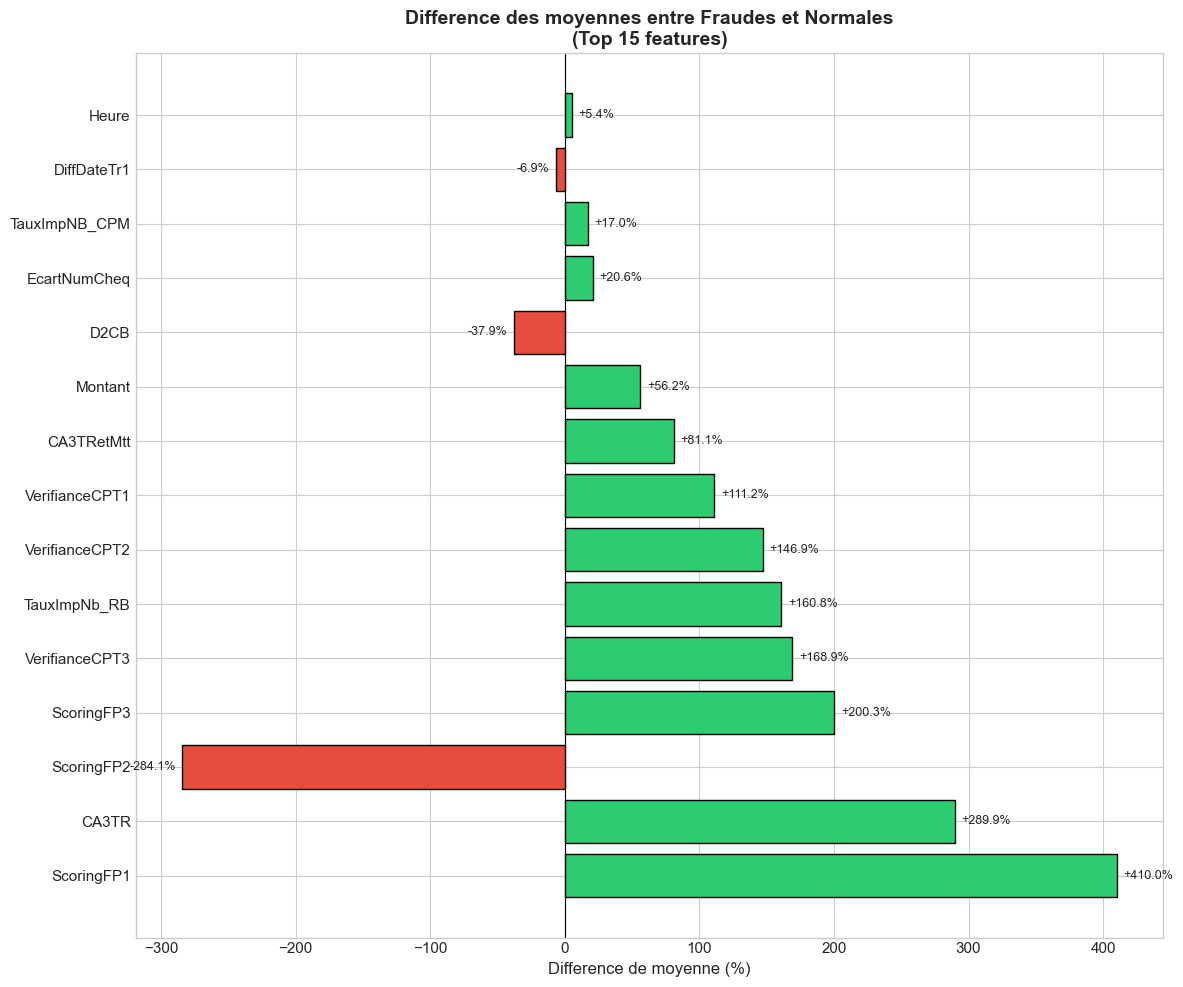

In [15]:
# Visualisation des differences
fig, ax = plt.subplots(figsize=(12, 10))

# Top 15 features par difference
top_diff = class_stats.head(15)

colors = ['#e74c3c' if x < 0 else '#2ecc71' for x in top_diff['diff_pct']]
bars = ax.barh(top_diff['feature'], top_diff['diff_pct'], color=colors, edgecolor='black')

ax.axvline(x=0, color='black', linewidth=0.8)
ax.set_xlabel('Difference de moyenne (%)', fontsize=12)
ax.set_title('Difference des moyennes entre Fraudes et Normales\n(Top 15 features)', fontsize=14, fontweight='bold')

# Ajouter les valeurs
for bar, val in zip(bars, top_diff['diff_pct']):
    x_pos = val + 5 if val >= 0 else val - 5
    ha = 'left' if val >= 0 else 'right'
    ax.text(x_pos, bar.get_y() + bar.get_height()/2, f'{val:+.1f}%', 
            va='center', ha=ha, fontsize=9)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'feature_differences.png', dpi=300, bbox_inches='tight')
plt.show()

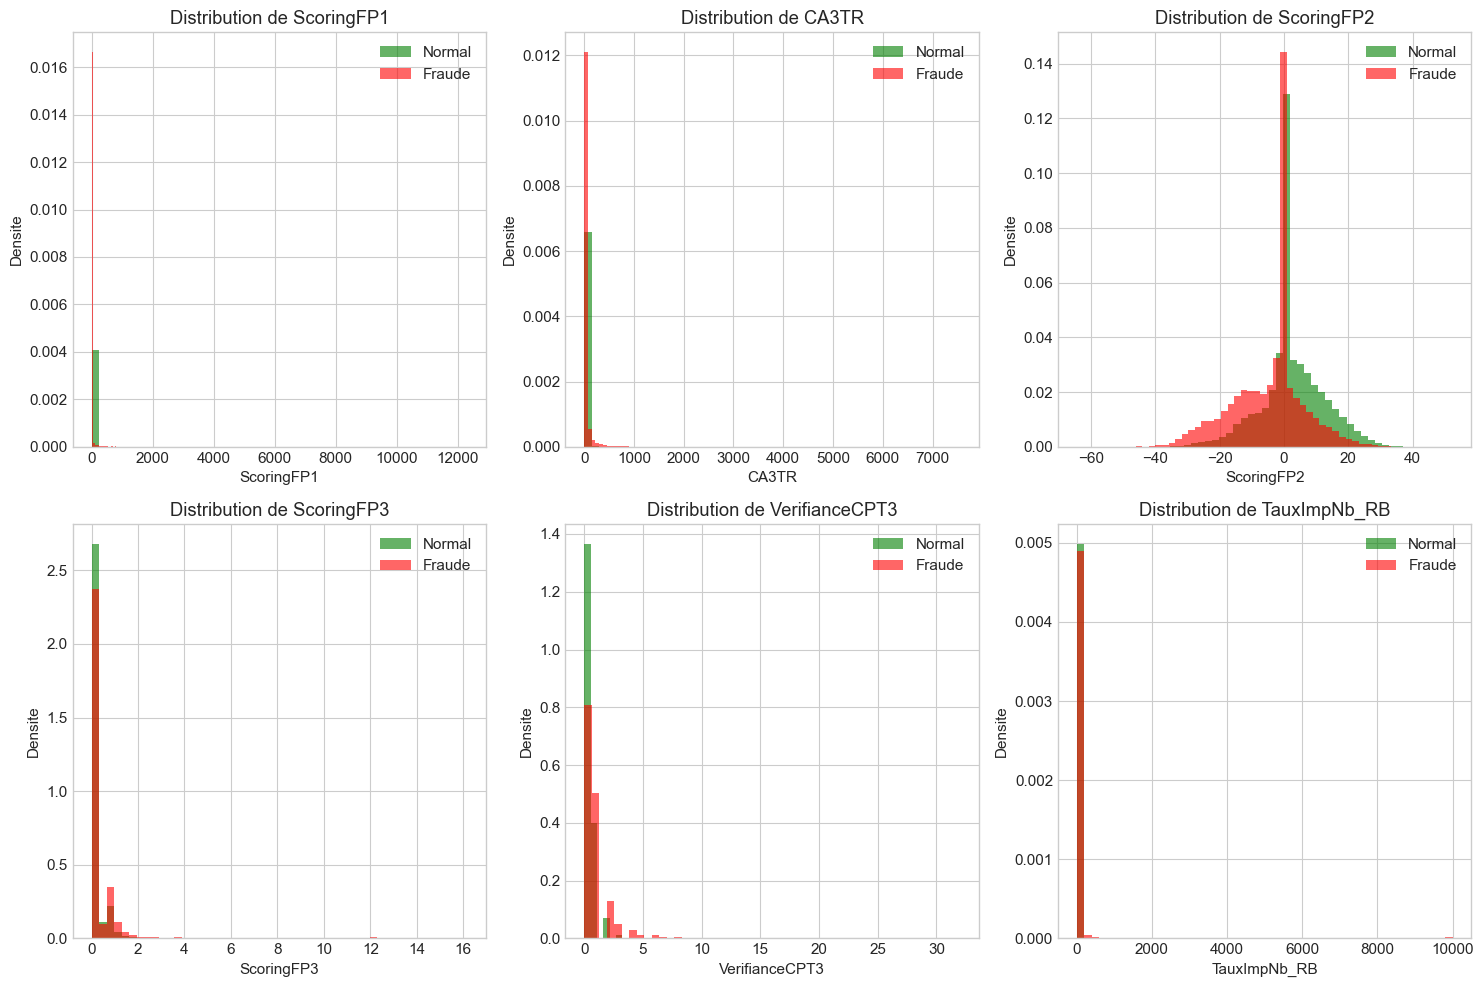

In [16]:
# Distribution des features les plus discriminantes
top_features = class_stats.head(6)['feature'].tolist()

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, feat in enumerate(top_features):
    ax = axes[idx]
    
    # Donnees par classe
    data_normal = X_train.loc[y_train == 0, feat]
    data_fraud = X_train.loc[y_train == 1, feat]
    
    # Histogrammes superposes
    ax.hist(data_normal, bins=50, alpha=0.6, label='Normal', color='green', density=True)
    ax.hist(data_fraud, bins=50, alpha=0.6, label='Fraude', color='red', density=True)
    
    ax.set_xlabel(feat)
    ax.set_ylabel('Densite')
    ax.set_title(f'Distribution de {feat}')
    ax.legend()

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'top_features_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

## 6. Correlations entre features

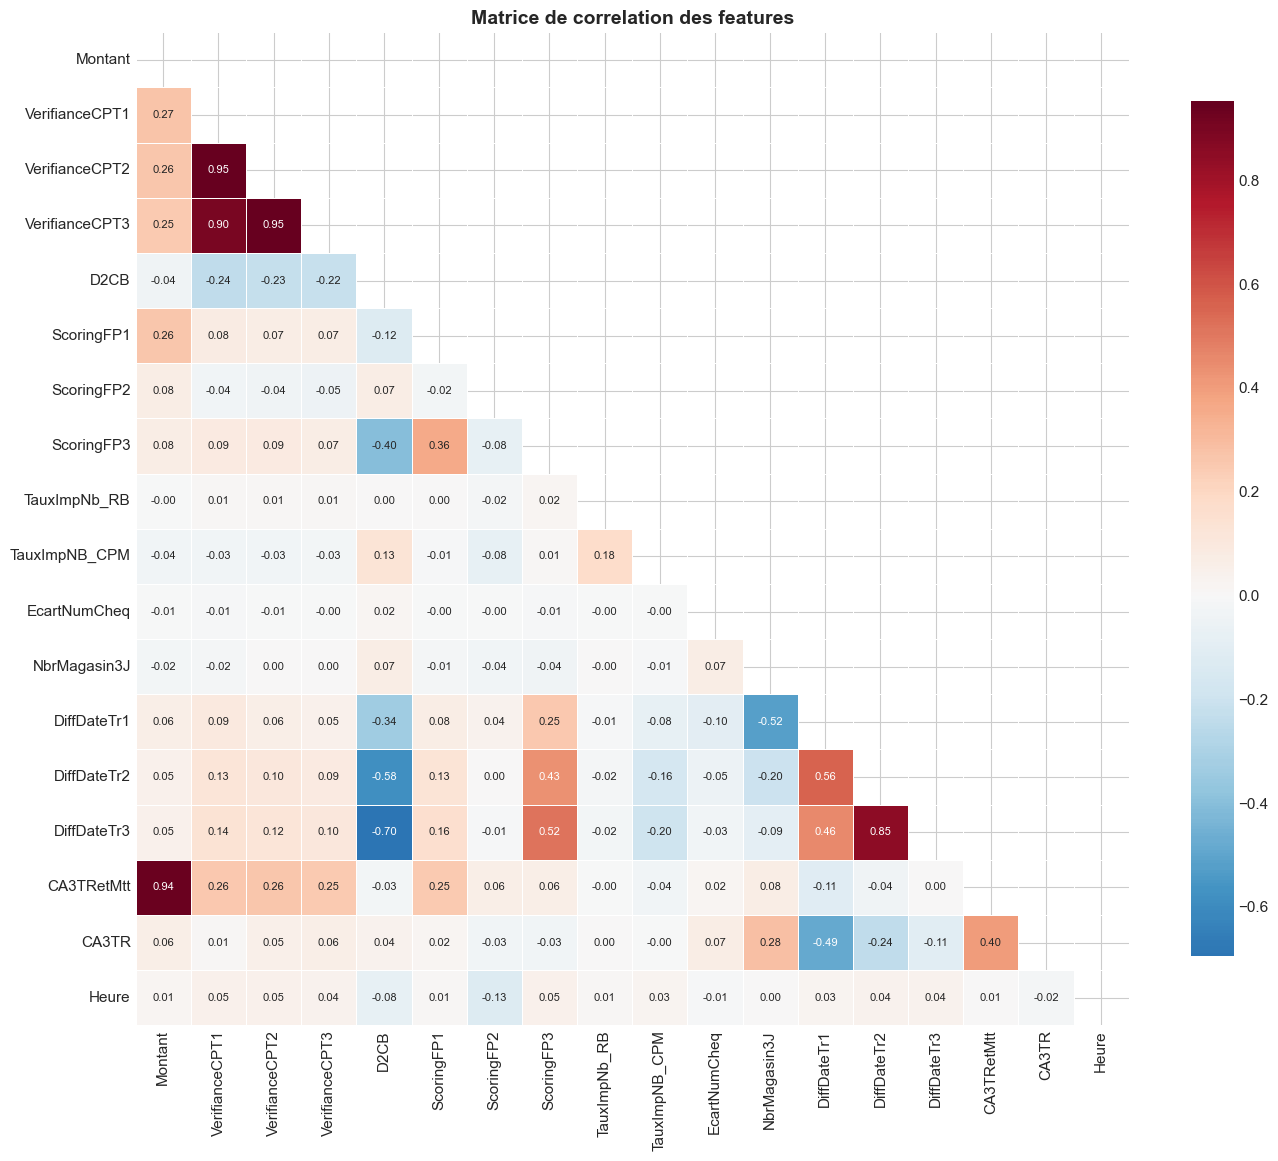

In [17]:
# Matrice de correlation des features
corr_matrix = X_train.corr()

# Heatmap
plt.figure(figsize=(14, 12))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='RdBu_r', center=0,
            fmt='.2f', square=True, linewidths=0.5, cbar_kws={'shrink': 0.8},
            annot_kws={'size': 8})
plt.title('Matrice de correlation des features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'feature_correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

In [18]:
# Identifier les features tres correlees (potentielle multicolinearite)
print("\nPaires de features fortement correlees (|corr| > 0.7):")
print("-" * 60)

high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.7:
            high_corr_pairs.append({
                'feature_1': corr_matrix.columns[i],
                'feature_2': corr_matrix.columns[j],
                'correlation': corr_matrix.iloc[i, j]
            })

if high_corr_pairs:
    high_corr_df = pd.DataFrame(high_corr_pairs).sort_values('correlation', key=abs, ascending=False)
    for _, row in high_corr_df.iterrows():
        print(f"   {row['feature_1']:20s} <-> {row['feature_2']:20s}: {row['correlation']:+.3f}")
else:
    print("   Aucune paire avec correlation > 0.7")


Paires de features fortement correlees (|corr| > 0.7):
------------------------------------------------------------
   VerifianceCPT1       <-> VerifianceCPT2      : +0.953
   VerifianceCPT2       <-> VerifianceCPT3      : +0.948
   Montant              <-> CA3TRetMtt          : +0.939
   VerifianceCPT1       <-> VerifianceCPT3      : +0.898
   DiffDateTr2          <-> DiffDateTr3         : +0.848


## 7. Decision sur le scaling

Le scaling (normalisation/standardisation) est important pour certains algorithmes:
- **Necessaire**: SVM, KNN, Reseaux de neurones, Regression logistique
- **Non necessaire**: Arbres de decision, Random Forest, Gradient Boosting

On va preparer deux versions des donnees:
1. **Sans scaling**: pour les algorithmes bases sur les arbres
2. **Avec scaling (StandardScaler)**: pour les autres algorithmes

In [19]:
# Version sans scaling (pour arbres)
print("Version 1: Sans scaling")
print(f"   X_train: min={X_train.min().min():.2f}, max={X_train.max().max():.2f}")

# Sauvegarde
save_preprocessed_data(X_train, X_test, y_train, y_test, suffix='', verbose=True)

Version 1: Sans scaling
   X_train: min=-64.46, max=9956167.00

Donnees sauvegardees:
   X_train: c:\Users\HP\Desktop\Master2\fouille_de_donnee\projet_Fouilles_de_Données_Massives\notebooks\..\data\processed\X_train.pkl
   X_test: c:\Users\HP\Desktop\Master2\fouille_de_donnee\projet_Fouilles_de_Données_Massives\notebooks\..\data\processed\X_test.pkl
   y_train: c:\Users\HP\Desktop\Master2\fouille_de_donnee\projet_Fouilles_de_Données_Massives\notebooks\..\data\processed\y_train.pkl
   y_test: c:\Users\HP\Desktop\Master2\fouille_de_donnee\projet_Fouilles_de_Données_Massives\notebooks\..\data\processed\y_test.pkl


{'X_train': WindowsPath('c:/Users/HP/Desktop/Master2/fouille_de_donnee/projet_Fouilles_de_Données_Massives/notebooks/../data/processed/X_train.pkl'),
 'X_test': WindowsPath('c:/Users/HP/Desktop/Master2/fouille_de_donnee/projet_Fouilles_de_Données_Massives/notebooks/../data/processed/X_test.pkl'),
 'y_train': WindowsPath('c:/Users/HP/Desktop/Master2/fouille_de_donnee/projet_Fouilles_de_Données_Massives/notebooks/../data/processed/y_train.pkl'),
 'y_test': WindowsPath('c:/Users/HP/Desktop/Master2/fouille_de_donnee/projet_Fouilles_de_Données_Massives/notebooks/../data/processed/y_test.pkl')}

In [20]:
# Version avec scaling (pour SVM, NN, etc.)
print("\nVersion 2: Avec StandardScaler")
X_train_scaled, X_test_scaled, scaler = scale_features(X_train, X_test, method='standard')

print(f"   X_train_scaled: mean~{X_train_scaled.mean().mean():.4f}, std~{X_train_scaled.std().mean():.4f}")

# Sauvegarde
save_preprocessed_data(X_train_scaled, X_test_scaled, y_train, y_test, suffix='scaled', verbose=True)


Version 2: Avec StandardScaler
Scaling applique: standard
   X_train: (3899362, 18)
   X_test: (747411, 18)
   X_train_scaled: mean~0.0000, std~1.0000

Donnees sauvegardees:
   X_train: c:\Users\HP\Desktop\Master2\fouille_de_donnee\projet_Fouilles_de_Données_Massives\notebooks\..\data\processed\X_train_scaled.pkl
   X_test: c:\Users\HP\Desktop\Master2\fouille_de_donnee\projet_Fouilles_de_Données_Massives\notebooks\..\data\processed\X_test_scaled.pkl
   y_train: c:\Users\HP\Desktop\Master2\fouille_de_donnee\projet_Fouilles_de_Données_Massives\notebooks\..\data\processed\y_train_scaled.pkl
   y_test: c:\Users\HP\Desktop\Master2\fouille_de_donnee\projet_Fouilles_de_Données_Massives\notebooks\..\data\processed\y_test_scaled.pkl


{'X_train': WindowsPath('c:/Users/HP/Desktop/Master2/fouille_de_donnee/projet_Fouilles_de_Données_Massives/notebooks/../data/processed/X_train_scaled.pkl'),
 'X_test': WindowsPath('c:/Users/HP/Desktop/Master2/fouille_de_donnee/projet_Fouilles_de_Données_Massives/notebooks/../data/processed/X_test_scaled.pkl'),
 'y_train': WindowsPath('c:/Users/HP/Desktop/Master2/fouille_de_donnee/projet_Fouilles_de_Données_Massives/notebooks/../data/processed/y_train_scaled.pkl'),
 'y_test': WindowsPath('c:/Users/HP/Desktop/Master2/fouille_de_donnee/projet_Fouilles_de_Données_Massives/notebooks/../data/processed/y_test_scaled.pkl')}

In [21]:
# Sauvegarder aussi le scaler pour pouvoir transformer de nouvelles donnees
import joblib

scaler_path = PROCESSED_DATA_DIR / 'scaler.joblib'
joblib.dump(scaler, scaler_path)
print(f"\nScaler sauvegarde: {scaler_path}")


Scaler sauvegarde: c:\Users\HP\Desktop\Master2\fouille_de_donnee\projet_Fouilles_de_Données_Massives\notebooks\..\data\processed\scaler.joblib


## 8. Resume du preprocessing

In [24]:
print("\n" + "=" * 70)
print("RESUME DU PREPROCESSING")
print("=" * 70)

print(f"\n[FEATURES]")
print(f"   Nombre de features: {len(feature_cols)}")
print(f"   Features selectionnees: {feature_cols}")

print(f"\n[COLONNES EXCLUES]")
for col in COLUMNS_TO_EXCLUDE:
    print(f"   - {col}")

print(f"\n[DIMENSIONS]")
print(f"   X_train: {X_train.shape}")
print(f"   X_test:  {X_test.shape}")

print(f"\n[DESEQUILIBRE]")
print(f"   Train - Taux de fraude: {y_train.mean()*100:.2f}% (ratio 1:{1/y_train.mean():.0f})")
print(f"   Test  - Taux de fraude: {y_test.mean()*100:.2f}% (ratio 1:{1/y_test.mean():.0f})")

print(f"\n[FEATURES LES PLUS DISCRIMINANTES]")
for i, row in class_stats.head(5).iterrows():
    print(f"   {i+1}. {row['feature']:25s} (diff: {row['diff_pct']:+.1f}%)")

print(f"\n[FICHIERS SAUVEGARDES]")
print(f"   - X_train.pkl, X_test.pkl, y_train.pkl, y_test.pkl (sans scaling)")
print(f"   - X_train_scaled.pkl, X_test_scaled.pkl (avec StandardScaler)")
print(f"   - scaler.joblib")



print("\n" + "=" * 70)


RESUME DU PREPROCESSING

[FEATURES]
   Nombre de features: 18
   Features selectionnees: ['Montant', 'VerifianceCPT1', 'VerifianceCPT2', 'VerifianceCPT3', 'D2CB', 'ScoringFP1', 'ScoringFP2', 'ScoringFP3', 'TauxImpNb_RB', 'TauxImpNB_CPM', 'EcartNumCheq', 'NbrMagasin3J', 'DiffDateTr1', 'DiffDateTr2', 'DiffDateTr3', 'CA3TRetMtt', 'CA3TR', 'Heure']

[COLONNES EXCLUES]
   - ZIBZIN
   - IDAvisAutorisationCheque
   - DateTransaction
   - CodeDecision

[DIMENSIONS]
   X_train: (3899362, 18)
   X_test:  (747411, 18)

[DESEQUILIBRE]
   Train - Taux de fraude: 0.60% (ratio 1:166)
   Test  - Taux de fraude: 0.88% (ratio 1:114)

[FEATURES LES PLUS DISCRIMINANTES]
   6. ScoringFP1                (diff: +410.0%)
   17. CA3TR                     (diff: +289.9%)
   7. ScoringFP2                (diff: -284.1%)
   8. ScoringFP3                (diff: +200.3%)
   4. VerifianceCPT3            (diff: +168.9%)

[FICHIERS SAUVEGARDES]
   - X_train.pkl, X_test.pkl, y_train.pkl, y_test.pkl (sans scaling)
   - X